In [2]:
# Systems and paths
import sys
import os
dir_name = os.getcwd().split('/')[-1]
parent_path = os.getcwd()[:-(len(dir_name) + 1)]
sys.path.append(parent_path)

In [3]:
import jax
import jax.numpy as np
import numpy as onp
from astropy.io import fits
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


In [4]:
# Define simulation parameters
aperture = 0.018 # 18mm
wl = 525e-9 # 525nm - Central green band on RBP cam
fl = 0.15 # 15cm camera lens
npix = 128 # Only simulate central region
pix_size = 1.12e-6 # 1.12 microns
tf_size = 2**9

In [5]:
from scipy.ndimage import zoom

def scale_pupil(pupil, output_size):
    """
    Takes in the complex pupil array and returns a scaled version
    BUGS: 
    This does not work correctly on pupils with the side lobe gratings
    Inputs:
        pupil: 2D Complex np array of the phase pupil
        output_size: Size of the pupil array to be returned
    Returns:
        pupil_scaled: 2D Complex np array of the pupil in the dimension of output_size X output_size
    """
    # Scale the real component of the pupil to this size
    size_in = pupil.shape[0]
    ratio = output_size/size_in    
    Re_scaled = zoom(pupil.real, ratio)
    # Create the new pupil from a real and imaginary component
    pupil_scaled = Re_scaled + onp.zeros([output_size, output_size]) * 1j
    # Create the masks to fix the values of the pupil
    norm_phase = onp.logical_and(np.abs(pupil_scaled) != 0, np.angle(pupil_scaled) == 0)
    anti_phase = onp.logical_and(np.abs(pupil_scaled) != 0, 
                                np.logical_or(np.angle(pupil_scaled) == np.pi, np.angle(pupil_scaled) == -np.pi))
    c = output_size//2
    s = onp.linspace(-c, c, num=output_size, endpoint=False)
    X,Y = onp.meshgrid(s, s)
    R = onp.hypot(X,Y)
    # Assign the correct values to the new array
    pupil_scaled[norm_phase] = onp.complex(1, 0)
    pupil_scaled[anti_phase] = onp.complex(-1, 0)
    pupil_scaled[R >= c-1] = onp.complex(0, 0)
    return pupil_scaled

def pupil_from_fits(file_name):
    """
    Takes in the fits file and returns a complex array of the pupil
    """
    # Create a fits object from astropy
    fits_file = fits.open(file_name)[0].data
    array = onp.array(fits_file)
    # Calculate needed values
    gridsize = array.shape[0]
    c = gridsize//2
    # Create value arrays
    Xs = onp.linspace(-c, c-1, num=gridsize)
    X, Y = onp.meshgrid(Xs, Xs)
    r = onp.hypot(X, Y)
    # Create pupil
    pupil = onp.exp(1j*array)
    # Zero outer regions
    pupil[r >= (gridsize//2)] = onp.complex(0,0)
    return pupil

In [6]:
pupil_in = pupil_from_fits("pupil.fits")
plate_scale = pix_size/fl    # Radians per pixel
spatial_freq = wl/aperture
scale_factor = spatial_freq/plate_scale
size_out = int(tf_size/scale_factor)
pupil = scale_pupil(pupil_in, size_out)

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### Now we apply morphine

In [7]:
import morphine

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


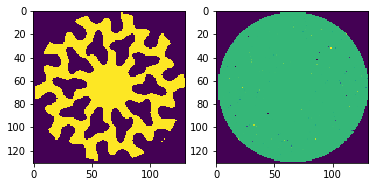

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,12))
ax1.imshow(np.angle(pupil))
trans = ax2.imshow(np.abs(pupil))


In [9]:
pdiam = aperture
ppscale = pdiam/np.shape(pupil)[0]

toliman = morphine.ArrayOpticalElement(opd=np.angle(pupil),
                               transmission=np.abs(pupil),
                               pixelscale=ppscale,
                               name='toliman',planetype=1)
toliman.pupil_diam = pdiam

In [10]:
WAVELENGTH = wl
ISZ = 128
PIXSCALE  =  1.0
FOV = ISZ*PIXSCALE # arcsec
PSZ = pupil.shape[0]


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4627: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in arange is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


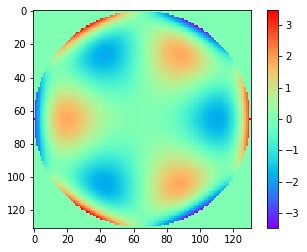

In [11]:
NZ = 20

zernikes = morphine.zernike.zernike_basis(NZ,npix=PSZ,outside=0.0)
plt.imshow(zernikes[-3,:,:],cmap=phasemap)
plt.colorbar()

In [12]:
coefficients_sequence = 15e-9*onp.random.randn(NZ)
pmask = np.abs(pupil).copy()

toliman_new = morphine.ArrayOpticalElement(opd=np.angle(pupil)*WAVELENGTH/2./np.pi,
                               transmission=np.abs(pupil),
                               pixelscale=ppscale,
                               name='toliman',planetype=1)
toliman_new.pupil_diam = pdiam

aberrated = morphine.OpticalSystem(npix=PSZ)
aberrated.add_pupil(toliman_new)    # pupil radius in meters
aberrated.pupil_diameter = pdiam
wf = aberrated.input_wavefront()

thinlens = morphine.ZernikeWFE(radius=pdiam/2., coefficients=coefficients_sequence, cached_zernikes=zernikes)
aberrated.add_pupil(thinlens)
aberrated.add_detector( pixelscale=PIXSCALE*2, fov_arcsec=2.*ISZ*PIXSCALE )

blur,intermediate = aberrated.propagate_mono(WAVELENGTH,normalize='first')

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4627: UserWarning: Explicitly requested dtype <class 'numpy.complex128'> requested in ones is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4627: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/jax/lax

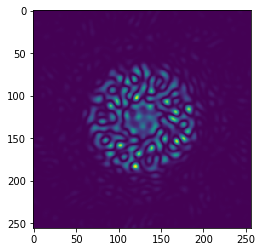

In [13]:
plt.imshow(blur.intensity,interpolation='none')

In [14]:

def psf_from_zernikes(coefficients_sequence):

    toliman_new = morphine.ArrayOpticalElement(opd=np.angle(pupil)*WAVELENGTH/2./np.pi,
                                   transmission=np.abs(pupil),
                                   pixelscale=ppscale,
                                   name='toliman',planetype=1)
    toliman_new.pupil_diam = pdiam

    aberrated = morphine.OpticalSystem(npix=PSZ)
    aberrated.add_pupil(toliman_new)    # pupil radius in meters
    aberrated.pupil_diameter = pdiam
    wf = aberrated.input_wavefront()

    thinlens = morphine.ZernikeWFE(radius=pdiam/2., coefficients=coefficients_sequence, cached_zernikes=zernikes)
    aberrated.add_pupil(thinlens)
    aberrated.add_detector( pixelscale=PIXSCALE*2, fov_arcsec=2.*ISZ*PIXSCALE )

    blur,intermediate = aberrated.propagate_mono(WAVELENGTH,normalize='first')
    return blur.intensity

In [15]:
from jax import jacfwd

In [16]:
jac_zernikes = jacfwd(psf_from_zernikes)

In [17]:
%%time
jacobian = jac_zernikes(np.zeros_like(np.zeros(NZ)))

CPU times: user 1.91 s, sys: 53.8 ms, total: 1.96 s
Wall time: 1.51 s


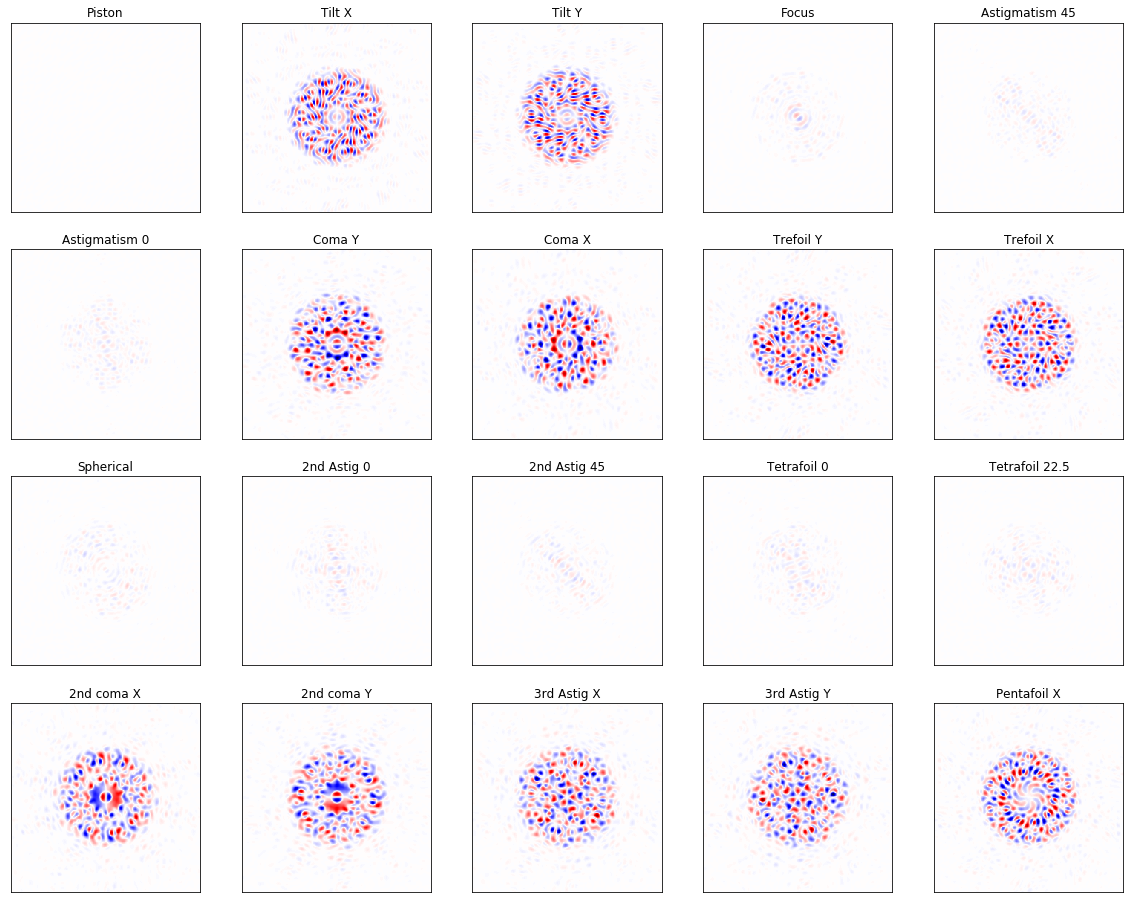

In [18]:
fig, axes = plt.subplots(4,5,figsize=(20,16))

vmin, vmax = onp.nanmin(jacobian),onp.nanmax(jacobian)

for j, ax in enumerate(axes.ravel()):
    ax.imshow(jacobian[:,:,j],vmin=vmin,vmax=vmax,cmap=mpl.cm.seismic)
    ax.set_title(morphine.zernike.zern_name(j+1))
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('toliman_zernikes.png',bbox_inches='tight')

In [20]:
np.angle(pupil).max()

DeviceArray(3.1415925, dtype=float32)